### Exploration: Let's explore this Zillow dataset.  We will examine and prepare the data we have using what we have written in our preparation scripts and plot/test our data to examine trends and identify clusters to help us indicate what perhaps may be driving the error in the Zestimate.

Prepare your environment:

In [1]:
# for acquiring:
import numpy as np
import pandas as pd
# for plotting:
import matplotlib.pyplot as plt
import seaborn as sns
# for analysis:
import scipy.stats as stats
# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
#for specific acq and prep:
from acquire_zillow import *
from prepare_zillow import *
from explore_zillow import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.cluster import KMeans

from scipy.stats import pearsonr



Get your data: get_zillow acquires the data from an sql query and creates a csv.  We will run this to acquire our dataset for reproducability.  (I have included a commented line for reading from the csv once created to ease my personal workflow after the initial query)

In [2]:
# df = get_zillow()
df = pd.read_csv('zillow.csv')

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# take a quick look at our data:
peekatdata(df)
value_counts(df)

        id  parcelid  basementsqft  bathroomcnt  bedroomcnt  \
0  2931667  11016594           NaN          2.0         3.0   
1   475764  14366692           NaN          3.5         4.0   
2  2444575  12098116           NaN          3.0         2.0   
3  1584730  12643413           NaN          2.0         2.0   
4  2926916  14432541           NaN          2.5         4.0   

   buildingqualitytypeid  calculatedbathnbr  decktypeid  \
0                    4.0                2.0         NaN   
1                    NaN                3.5         NaN   
2                    4.0                3.0         NaN   
3                    4.0                2.0         NaN   
4                    NaN                2.5         NaN   

   finishedfloor1squarefeet  calculatedfinishedsquarefeet  \
0                       NaN                        1684.0   
1                       NaN                        2263.0   
2                       NaN                        2217.0   
3                     

KeyError: "['parcel_id'] not found in axis"

In [4]:
# Below we will utilize a combination of functions into a prep_zillow() function.
# descriptions are in prepare_zillow.py, but we will proceed to fill some zeros, then use our main
# prepatory function.  We will drop columns if more than half is empty, and rows if more than 3/4 is empty.
# we will remove establishments not perceived to be single peroperties.
# we will impute lotsize based on a linear regression with tax value of property.
# we will remove outliers that don't fit our perception of utility in this context.




# def prep_zillow(df):
#     df = handle_missing_values(df, prop_required_column=.5, prop_required_row=.75)
#     df = groom_singles(df)
#     df = numeric_to_categorical(df)
#     df = impute_lotsize(df)
#     df = maggies_manual_outliers(df)
#     df = drop_nas(df)
#     df.reset_index(inplace=True, drop=True)


In [5]:
#fill some of the column values with zeros based on what we see in our data dictionary.  
# pools and decks seem to only have values if they were observed based on the descriptions.
# fireplace, hot tub, and garage would generally be defaulted to zero as well unless noted as a feature to sell property
fill_zeros(df, ['decktypeid', 'fireplacecnt', 'garagecarcnt', 'hashottuborspa'])

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [6]:
# utilize prep function
# df.info()
# # decided to eliminate any rows with less than 75% of data filled and any columns with less than half
# df = handle_missing_values(df, prop_required_column=.5, prop_required_row=.75)
# # eliminate properties that dont seem to fit our single unit specs
# df = groom_singles(df)
# # take columsn we want to convert to categorical data to not be conflated with our numeric values
# df = numeric_to_categorical(df)
# # fix our indeces before we impute lotsize values
# df.reset_index(inplace=True, drop=True)
# # impute lotsize values based on data we have that is correlated from lotsizesquarefootage
# df = impute_lotsize(df)
# # remove some outliers manually
# df = maggies_manual_outliers(df)
df.reset_index(inplace=True, drop=True)
df = prep_zillow(df)


In [7]:
# slash and burn the rest
# drop_nas(df)
# df.info()

In [8]:
## scale numeric values in df:

scaler = MinMaxScaler()
num_vars = list(df.select_dtypes('number').columns)
num_vars = num_vars[1:-1]
# select more nuanced list of variables to scale as we don't want to scale every numberic variable

scale_vars = ['calculatedfinishedsquarefeet','lotsizesquarefeet','structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']
def scale_these(df, scale_vars): 
    scaler = MinMaxScaler()
    df[scale_vars] = scaler.fit_transform(df[scale_vars])
scale_these(df, scale_vars)


In [9]:
# add manually calculated bed and bath column to make up for redundancy and 
# error in calculatedbedandbath columns
df['bed_and_bath'] = df.fullbathcnt.astype('int') + df.bedroomcnt.astype('int')

In [10]:
#drop some columns interpreted as arbitrary.  unitcnt has served its purpose to narrow results, bfips is redundant with count,
# we calculated our own bed and bathroom, finishedsquareft12 is redudndant, bathroomcnt redudndant in light of fullbathcnt
df = df.drop(columns=['fips','unitcnt','calculatedbathnbr','finishedsquarefeet12','bathroomcnt', 'heatingorsystemdesc','propertyzoningdesc','assessmentyear'])

In [11]:
# drop some more.  county is arbitray based on the data we already eliminated. we will 
df.drop(columns=['bedroomcnt', 'fullbathcnt','roomcnt', 'calculatedfinishedsquarefeet'], inplace=True)

In [12]:
#create a list of columns that shall be treated categorically
cat_vars = ['buildingqualitytypeid', 'propertycountylandusecode','rawcensustractandblock', 'regionidcity', 'regionidcounty', 'transactiondate', 'propertylandusedesc', 'bed_and_bath']
# create a list of columns that shall be treated as continuous features
num_vars = list(df.select_dtypes('number').columns)
num_vars.remove('buildingqualitytypeid')
contin_vars = num_vars
contin_vars
contin_vars.remove('regionidcity')
contin_vars.remove('yearbuilt')


In [13]:
#reassign numvars with new  dataframe that includes bed_and_bath and removes dropped columns
num_vars = list(df.select_dtypes('number').columns)
#ignore parcelid:
num_vars = num_vars[1:]

### Now that our data is a bit cleaner, let's attempt some proper exploration.

In [14]:
peekatdata(df)

         id  parcelid  buildingqualitytypeid    latitude    longitude  \
0   2931667  11016594                    4.0  34280990.0 -118488536.0   
2   2444575  12098116                    4.0  34136312.0 -118175032.0   
5   2843942  11509835                    1.0  33870089.0 -118402768.0   
6   1628001  12286022                    7.0  33899475.0 -118212720.0   
10   715639  10854446                    7.0  34164671.0 -118477995.0   

    lotsizesquarefeet propertycountylandusecode  rawcensustractandblock  \
0            0.002352                      0100            6.037107e+07   
2            0.003727                      0100            6.037464e+07   
5            0.000649                      0100            6.037621e+07   
6            0.002051                      0100            6.037542e+07   
10           0.002617                      0100            6.037141e+07   

    regionidcity  regionidcounty     ...       yearbuilt  \
0        12447.0          3101.0     ...          

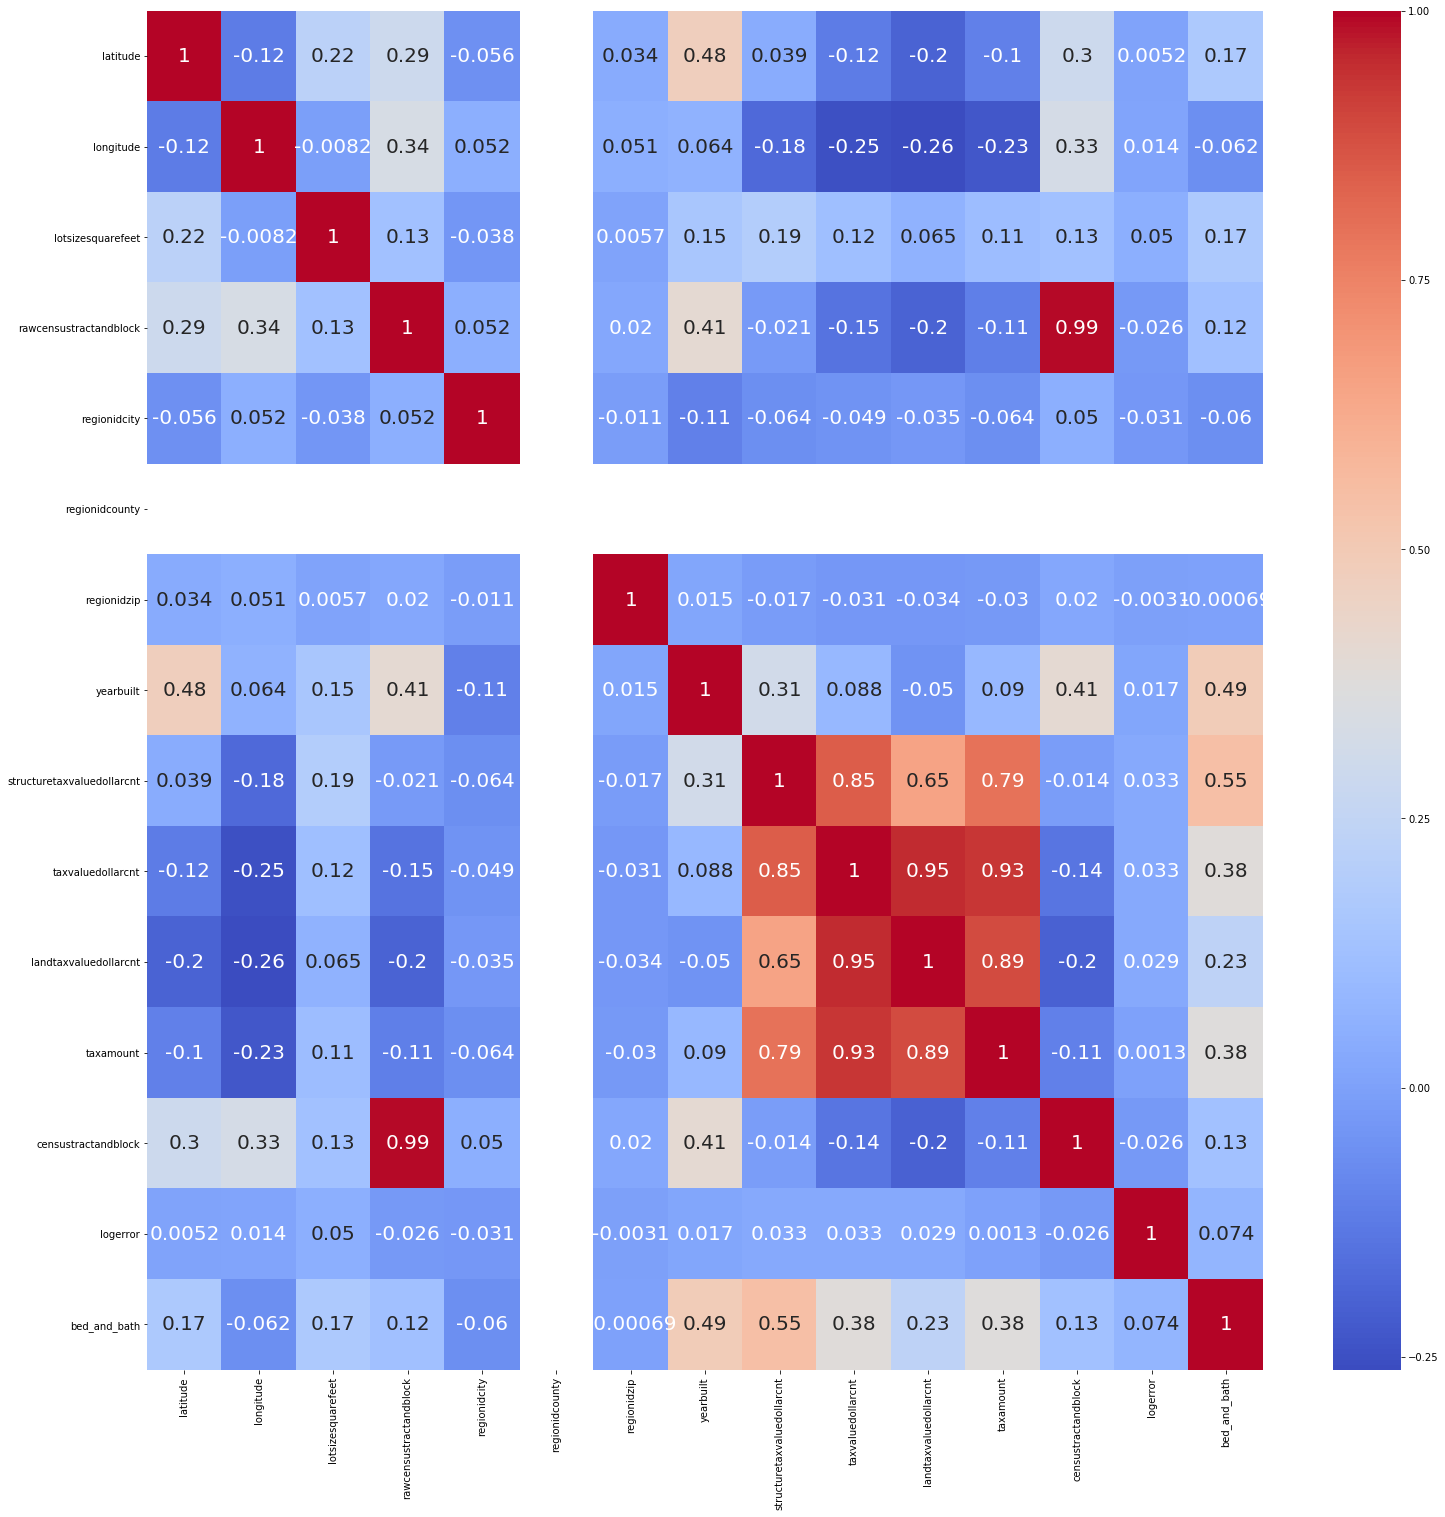

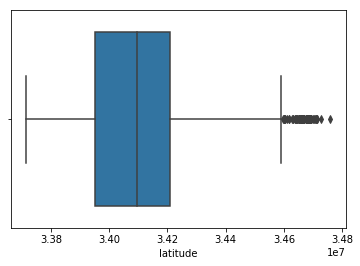

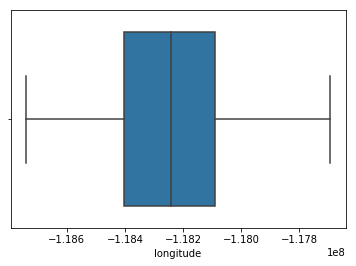

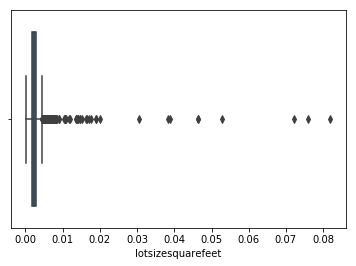

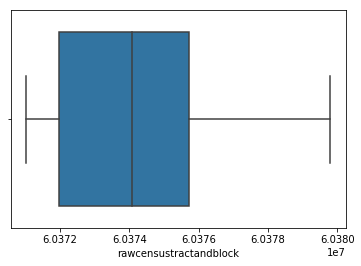

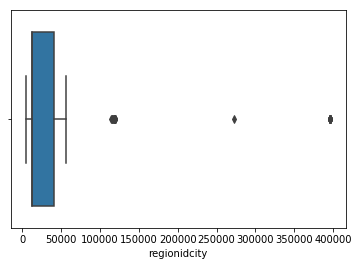

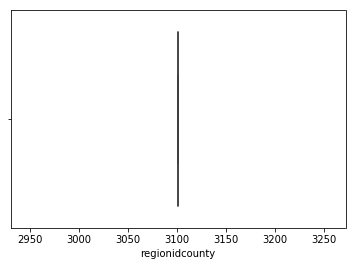

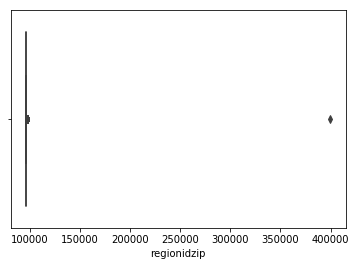

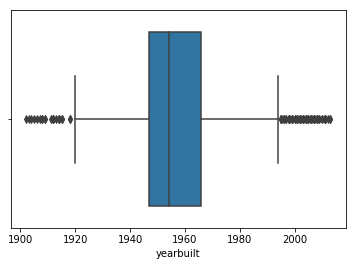

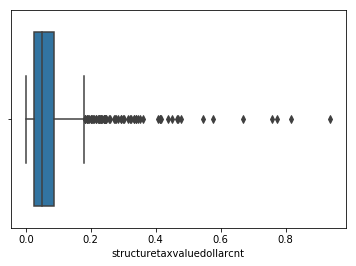

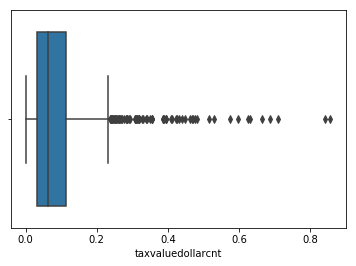

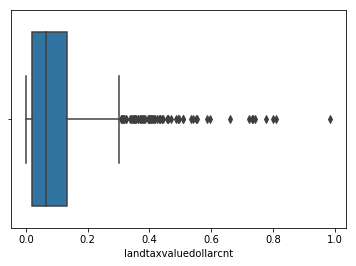

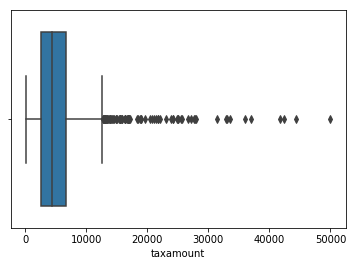

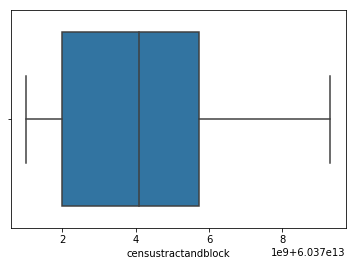

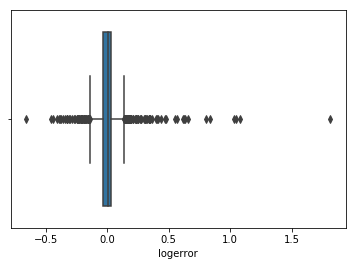

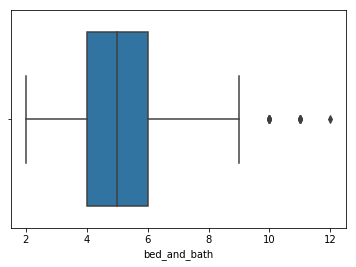

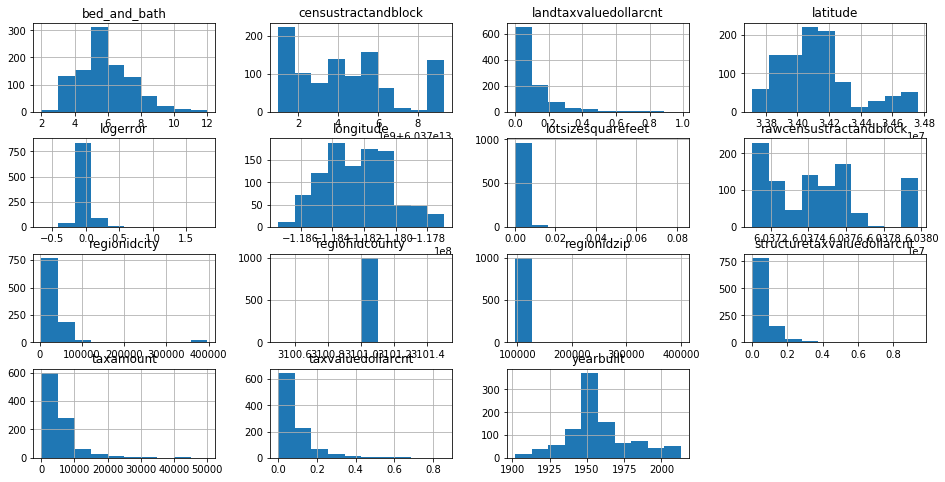

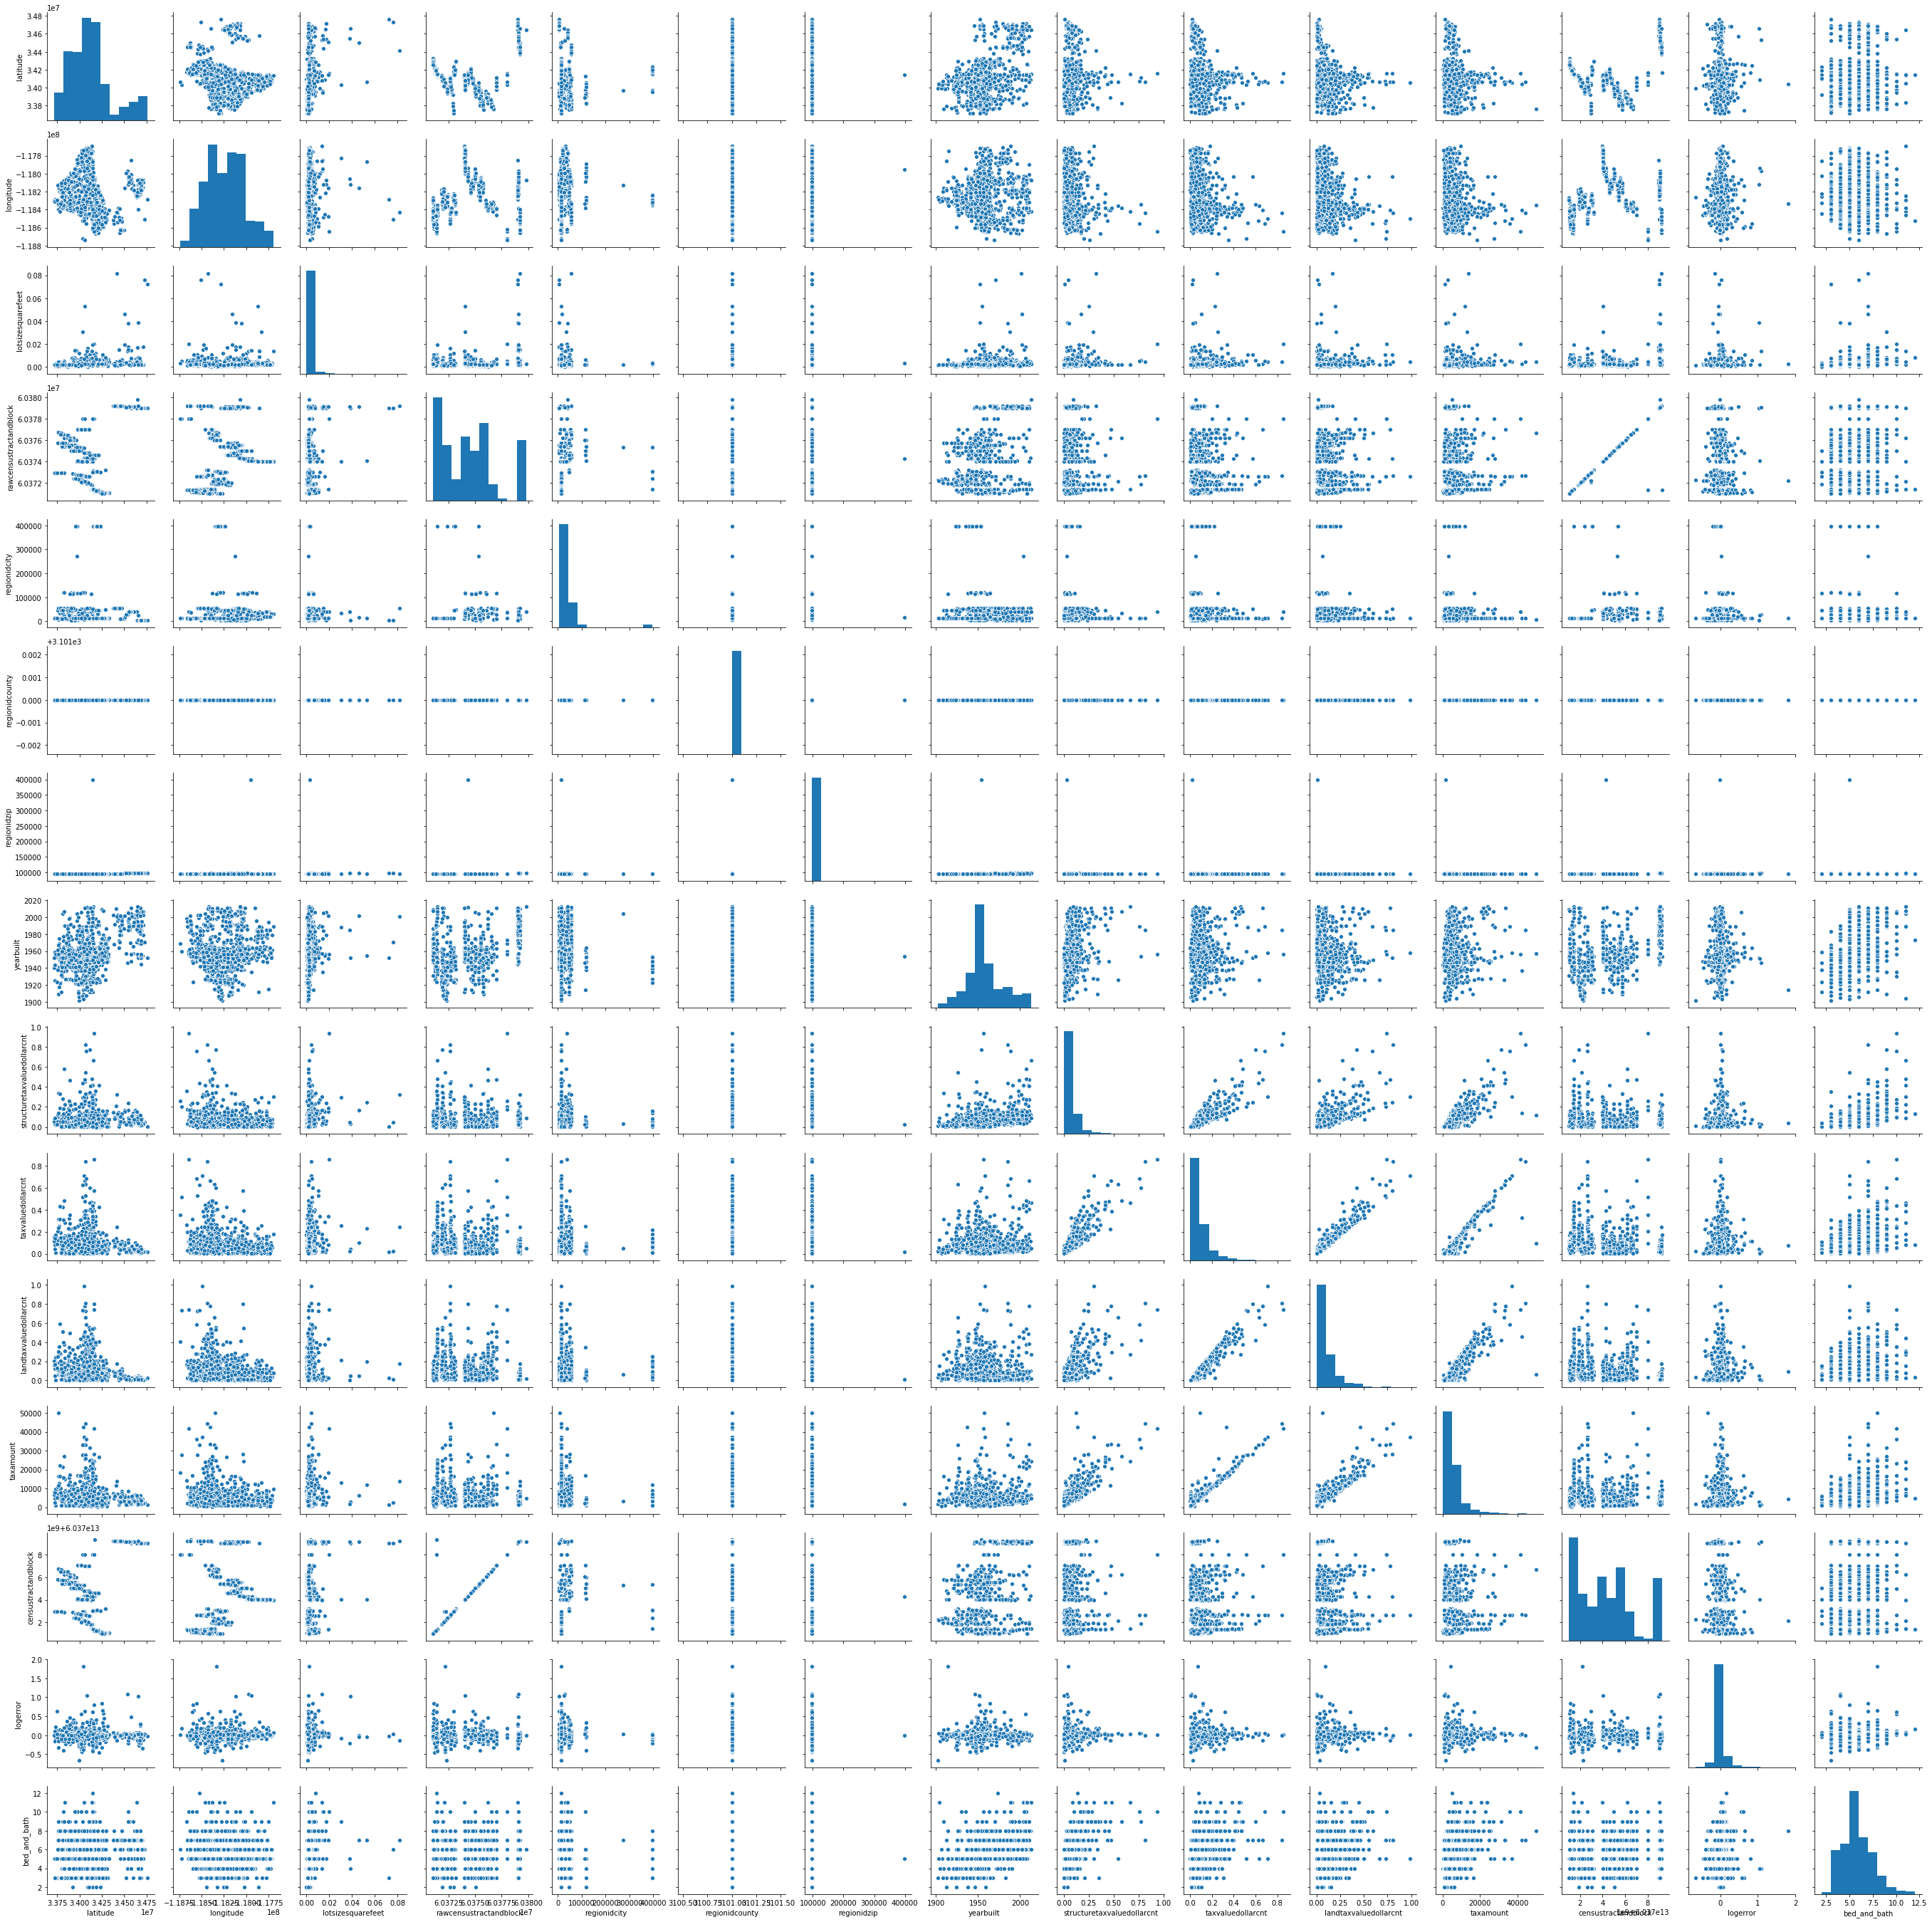

In [15]:
get_heat_pair_box(df.sample(1000), num_vars)

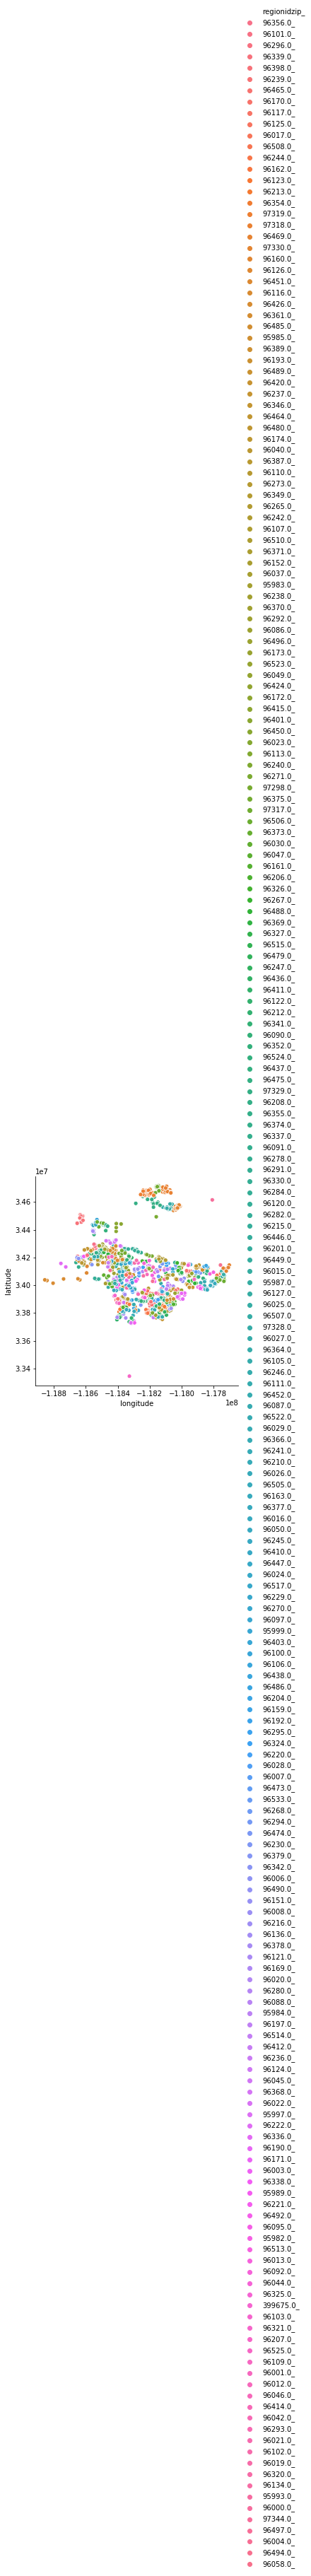

In [16]:
# relplot of latitude and longitude with zip codes for funsies
df['regionidzip_'] = df.regionidzip.astype('str') + '_'
sns.relplot(x='longitude',y='latitude', hue='regionidzip_', data = df.sample(1000))

In [17]:
# cat_vars.remove('regionidcounty')
# cat_vars.remove('propertylandusedesc')
cat_vars

['buildingqualitytypeid',
 'propertycountylandusecode',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'transactiondate',
 'propertylandusedesc',
 'bed_and_bath']

In [18]:
cat_vars.remove('transactiondate')

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


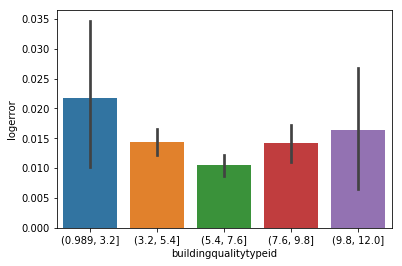

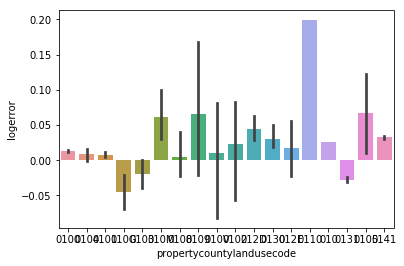

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


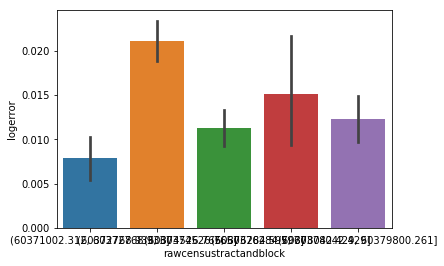

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


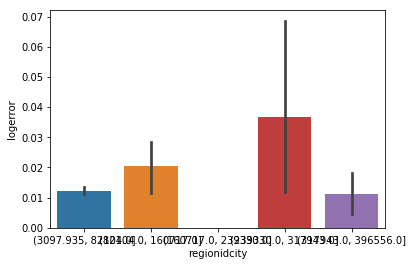

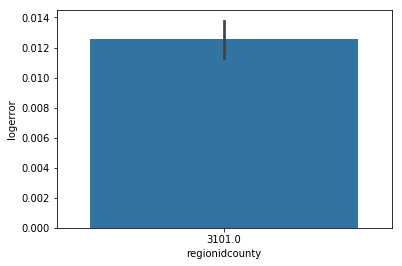

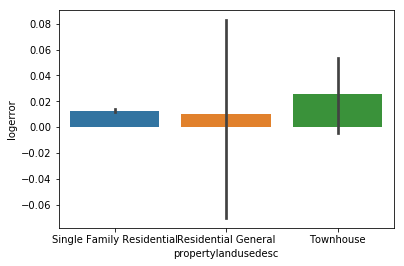

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


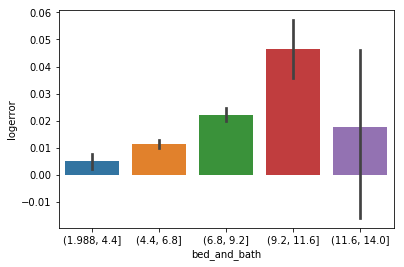

In [19]:
# bar plots of log error distribution for some of our categorical variables:
bars(df, cat_vars, cont_var='logerror')

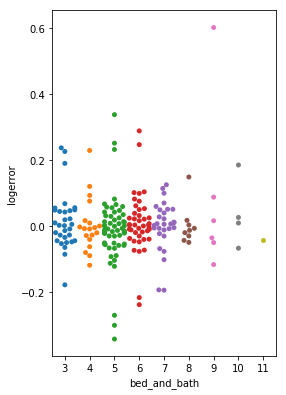

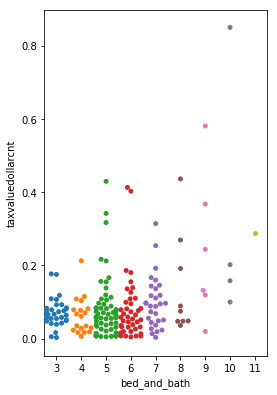

In [20]:
swarrrm(df.sample(200), 'bed_and_bath', ['logerror','taxvaluedollarcnt'])

### We will begin to test for difference between groups. to see if we can extrapolate any further meaning.

In [21]:
#let's try first a simple ttest between logerrors of establishments with 4 or less bed/bath and those with more
tstat, pval = stats.ttest_ind(df[df.bed_and_bath < 5].logerror, df[df.bed_and_bath > 4].logerror)
print('Our t-statistic is {:.4} and the p-value is {:.4}'.format(tstat, pval))

Our t-statistic is -7.434 and the p-value is 1.064e-13


as expected, something as simple as intuitive as this has a very low p-value and a significantly large t-stat by magnitude.  Let's run a few more of these to more finely discern our differences and run some categorical testing for variables using chi-squared methods.

In [22]:
df.bed_and_bath.value_counts()
#There are 13 groups for bed and bath counts.  let's run a chi-squared test to see if there is 
#significance in the way that logerror is distributed here.

5     20717
6     12534
4      9742
7      8208
3      7764
8      3439
9      1631
10      868
2       569
11      391
12      126
13       60
14        9
Name: bed_and_bath, dtype: int64

In [23]:
df['logerror_abs'] = df.logerror.abs()
df['logerror_abs_bin'] = pd.qcut(df.logerror_abs, 13, labels=False)

tbl = pd.crosstab(df['bed_and_bath'], df['logerror_abs_bin'])
print(tbl)
stat, p, dof, expected = stats.chi2_contingency(tbl)
print('chi-squared statistic: {}'.format(stat))
print('p-statistic of logerror bins vs location clusters: {}'.format(p))

logerror_abs_bin    0     1     2     3     4     5     6     7     8     9   \
bed_and_bath                                                                   
2                   18    30    25    23    25    37    33    48    51    54   
3                  513   513   558   521   594   562   584   579   576   608   
4                  701   687   730   720   704   750   730   758   721   754   
5                 1691  1720  1696  1568  1700  1609  1682  1562  1599  1561   
6                 1031   992  1092   977  1027   981   999   987   966   950   
7                  698   691   698   675   668   618   647   606   618   621   
8                  257   266   263   260   263   240   247   244   291   281   
9                   97    99   102   101   112   113   118   118   131   128   
10                  42    56    51    51    66    35    64    71    81    75   
11                  24    17    20    14    22    12    28    25    35    47   
12                   7     4     5     5

In [26]:
df.drop(columns='logerror_abs_bin', inplace=True)

We can assess some value here suggesting that our distribution of logerror is not evenly distributed due to a very low p-statistic.  We can reject the null hypothesis that would suggest that there is no difference in distribution between these groups.

### First clustering attempt:

In [27]:
#only log error:
X = df[['logerror']]

intertias = []
for numclusters in range(1, 11):
    kmeans = KMeans(n_clusters=numclusters)
    kmeans.fit(X)
    intertias.append(kmeans.inertia_)
    
kmeans_perf = pd.DataFrame(list(zip(range(1, 11), intertias)), columns=['n_clusters', 'ssd'])

Text(0.5, 1.0, 'The elbow method for logerror only')

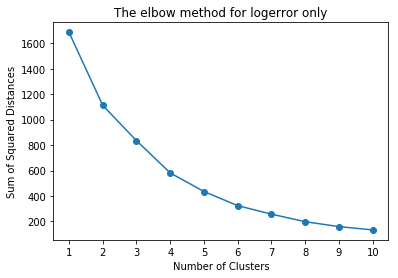

In [28]:
plt.scatter(kmeans_perf.n_clusters, kmeans_perf.ssd)
plt.plot(kmeans_perf.n_clusters, kmeans_perf.ssd)

plt.xticks(range(1, 11))
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('The elbow method for logerror only')

#### It looks like 4 clusters is a good standard to use with this elbow model.  We will append the results of a 4 cluster model to our dataframe.

In [31]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
df['cluster_target'] = kmeans.predict(X)

In [32]:
df['cluster_target'].head()

0     0
2     0
5     3
6     0
10    1
Name: cluster_target, dtype: int32

### Let's test the significance of this clustering:

In [33]:
#if we bin everythging by clusters, our null hypothesis would be that 
# there is a roughly 25% distribution of entries across these clusters.
# Let's see the value counts in each of these clusters.
df.cluster_target.value_counts()

0    60100
1     3917
3     1877
2      164
Name: cluster_target, dtype: int64

### These numbers don't exactly look distributed evenly.  
### Let's run a chi^2 test for significance.

In [34]:
# first bin the logerrors so that they match our clusters: 
df['logerror_bin'] = pd.qcut(df.logerror, 4, labels=False)


tbl = pd.crosstab(df['cluster_target'], df['logerror_bin'])
tbl

logerror_bin        0      1      2      3
cluster_target                            
0               14808  16565  16293  12434
1                   0      0      0   3917
2                   0      0      0    164
3                1877      0      0      0

In [35]:
stat, p, dof, expected = stats.chi2_contingency(tbl)

In [36]:
print('p-statistic of logerror bins vs logerror clusters: {}'.format(p))

p-statistic of logerror bins vs logerror clusters: 0.0


In [37]:
#investigate again utilizing the absolute value of the log error this time

df['logerror_abs_bin'] = pd.qcut(df.logerror_abs, 4, labels=False)

tbl = pd.crosstab(df['cluster_target'], df['logerror_abs_bin'])
tbl


logerror_abs_bin      0      1      2      3
cluster_target                              
0                 16515  16607  16421  10557
1                     0      0      0   3917
2                     0      0      0    164
3                     0      0      0   1877

In [38]:
#
stat, p, dof, expected = stats.chi2_contingency(tbl)
print('p-statistic of logerror bins vs logerror clusters: {}'.format(p))

for i in range(0,3):
    print(stats.ttest_ind(df[df.cluster_target == i].logerror,
                    df[df.cluster_target == (i+1)].logerror))

p-statistic of logerror bins vs logerror clusters: 0.0
Ttest_indResult(statistic=-271.97075207797764, pvalue=0.0)
Ttest_indResult(statistic=-81.94471164164278, pvalue=0.0)
Ttest_indResult(statistic=69.25260802759037, pvalue=0.0)


### still reading as zero, which makes a lot of sense considering we are comparing logerror to clusters based only upon logerror.

Let's try a new clustering based on latitude, longitude and

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


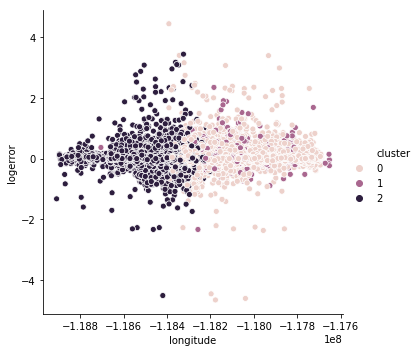

In [39]:
X = df[['longitude', 'latitude', 'logerror']]
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
X['cluster'] = kmeans.predict(X)

sns.relplot(data=X, x='longitude', y='logerror', hue='cluster')
 

In [40]:
X = df[['longitude', 'latitude', 'logerror']]

intertias = []
for numclusters in range(1, 11):
    kmeans = KMeans(n_clusters=numclusters)
    kmeans.fit(X)
    intertias.append(kmeans.inertia_)
    
kmeans_perf = pd.DataFrame(list(zip(range(1, 11), intertias)), columns=['n_clusters', 'ssd'])

Text(0.5, 1.0, 'The elbow method')

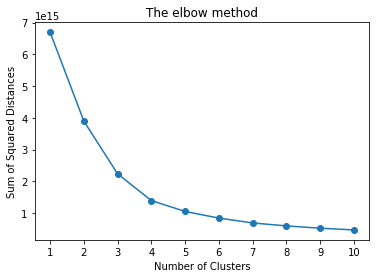

In [41]:
plt.scatter(kmeans_perf.n_clusters, kmeans_perf.ssd)
plt.plot(kmeans_perf.n_clusters, kmeans_perf.ssd)

plt.xticks(range(1, 11))
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('The elbow method')

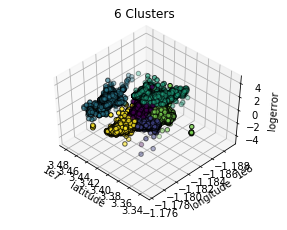

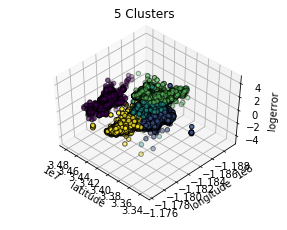

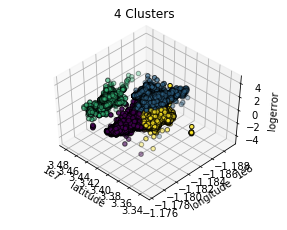

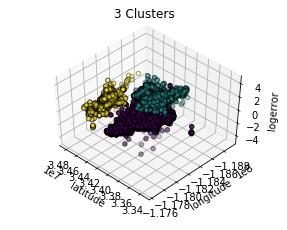

In [42]:
# visual comparison of Kmeans models using longitude/latitude and 

from mpl_toolkits.mplot3d import Axes3D


estimators = [('6 Clusters', KMeans(n_clusters=6)),
              ('5 Clusters', KMeans(n_clusters=5)),
              ('4 Clusters', KMeans(n_clusters=4)), 
             ('3 Clusters', KMeans(n_clusters=3))]

for i, (title, kmeans) in enumerate(estimators):
    # fit the model
    kmeans.fit(X)

    labels = kmeans.labels_

#     # setup the 3d plot
    fignum = i + 1
    fig = plt.figure(fignum, figsize=(4, 3))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

#     # plot the points
    ax.scatter(X.latitude, X.longitude, X.logerror,
               c=labels.astype(np.float), edgecolor='k')

#     ax.w_xaxis.set_ticklabels([])
#     ax.w_yaxis.set_ticklabels([])
#     ax.w_zaxis.set_ticklabels([])

    ax.set_xlabel('latitude')
    ax.set_ylabel('longitude')
    ax.set_zlabel('logerror')

    ax.set_title(title)
    ax.dist = 12

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


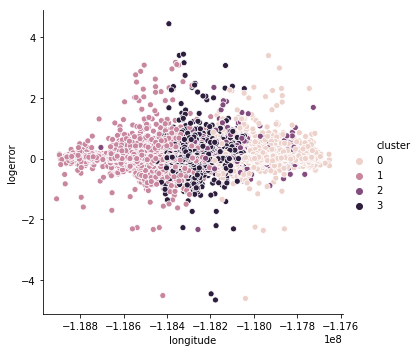

In [45]:
X = df[['longitude', 'latitude', 'logerror']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
X['cluster'] = kmeans.predict(X)

sns.relplot(data=X, x='longitude', y='logerror', hue='cluster')
 

Text(0.5, 1.0, 'The elbow method')

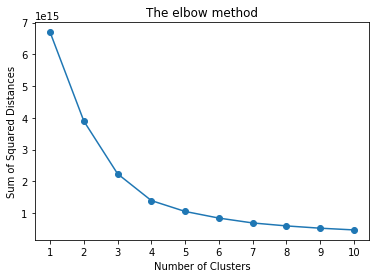

In [46]:
# clustering based strictly on location: 
X = df[['longitude', 'latitude']]

intertias = []
for numclusters in range(1, 11):
    kmeans = KMeans(n_clusters=numclusters)
    kmeans.fit(X)
    intertias.append(kmeans.inertia_)
    
kmeans_perf = pd.DataFrame(list(zip(range(1, 11), intertias)), columns=['n_clusters', 'ssd'])

plt.scatter(kmeans_perf.n_clusters, kmeans_perf.ssd)
plt.plot(kmeans_perf.n_clusters, kmeans_perf.ssd)

plt.xticks(range(1, 11))
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('The elbow method')

In [47]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
df['cluster_target_loc'] = kmeans.predict(X)

In [48]:
#add a new column for locational clusters
df['logerror_abs_bin'] = pd.qcut(df.logerror_abs, 4, labels=False)

tbl = pd.crosstab(df['cluster_target_loc'], df['logerror_abs_bin'])
print(tbl)
stat, p, dof, expected = stats.chi2_contingency(tbl)
print('p-statistic of logerror bins vs location clusters: {}'.format(p))

logerror_abs_bin       0     1     2     3
cluster_target_loc                        
0                   4834  4880  4870  4991
1                   4309  4288  4155  3869
2                   5257  5542  5811  6115
3                   2115  1897  1585  1540
p-statistic of logerror bins vs location clusters: 7.8755878239267635e-44


In [49]:
# We have a pretty low p-value here,
# we can reject the null hypothesis that these are proportionally distributed.

In [50]:
df0 = df[df.cluster_target_loc == 0]
df1 = df[df.cluster_target_loc == 1]
df2 = df[df.cluster_target_loc == 2]
df3 = df[df.cluster_target_loc == 3]

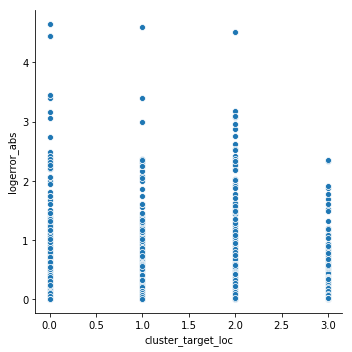

In [51]:
sns.relplot(x='cluster_target_loc', y='logerror_abs', data=df)

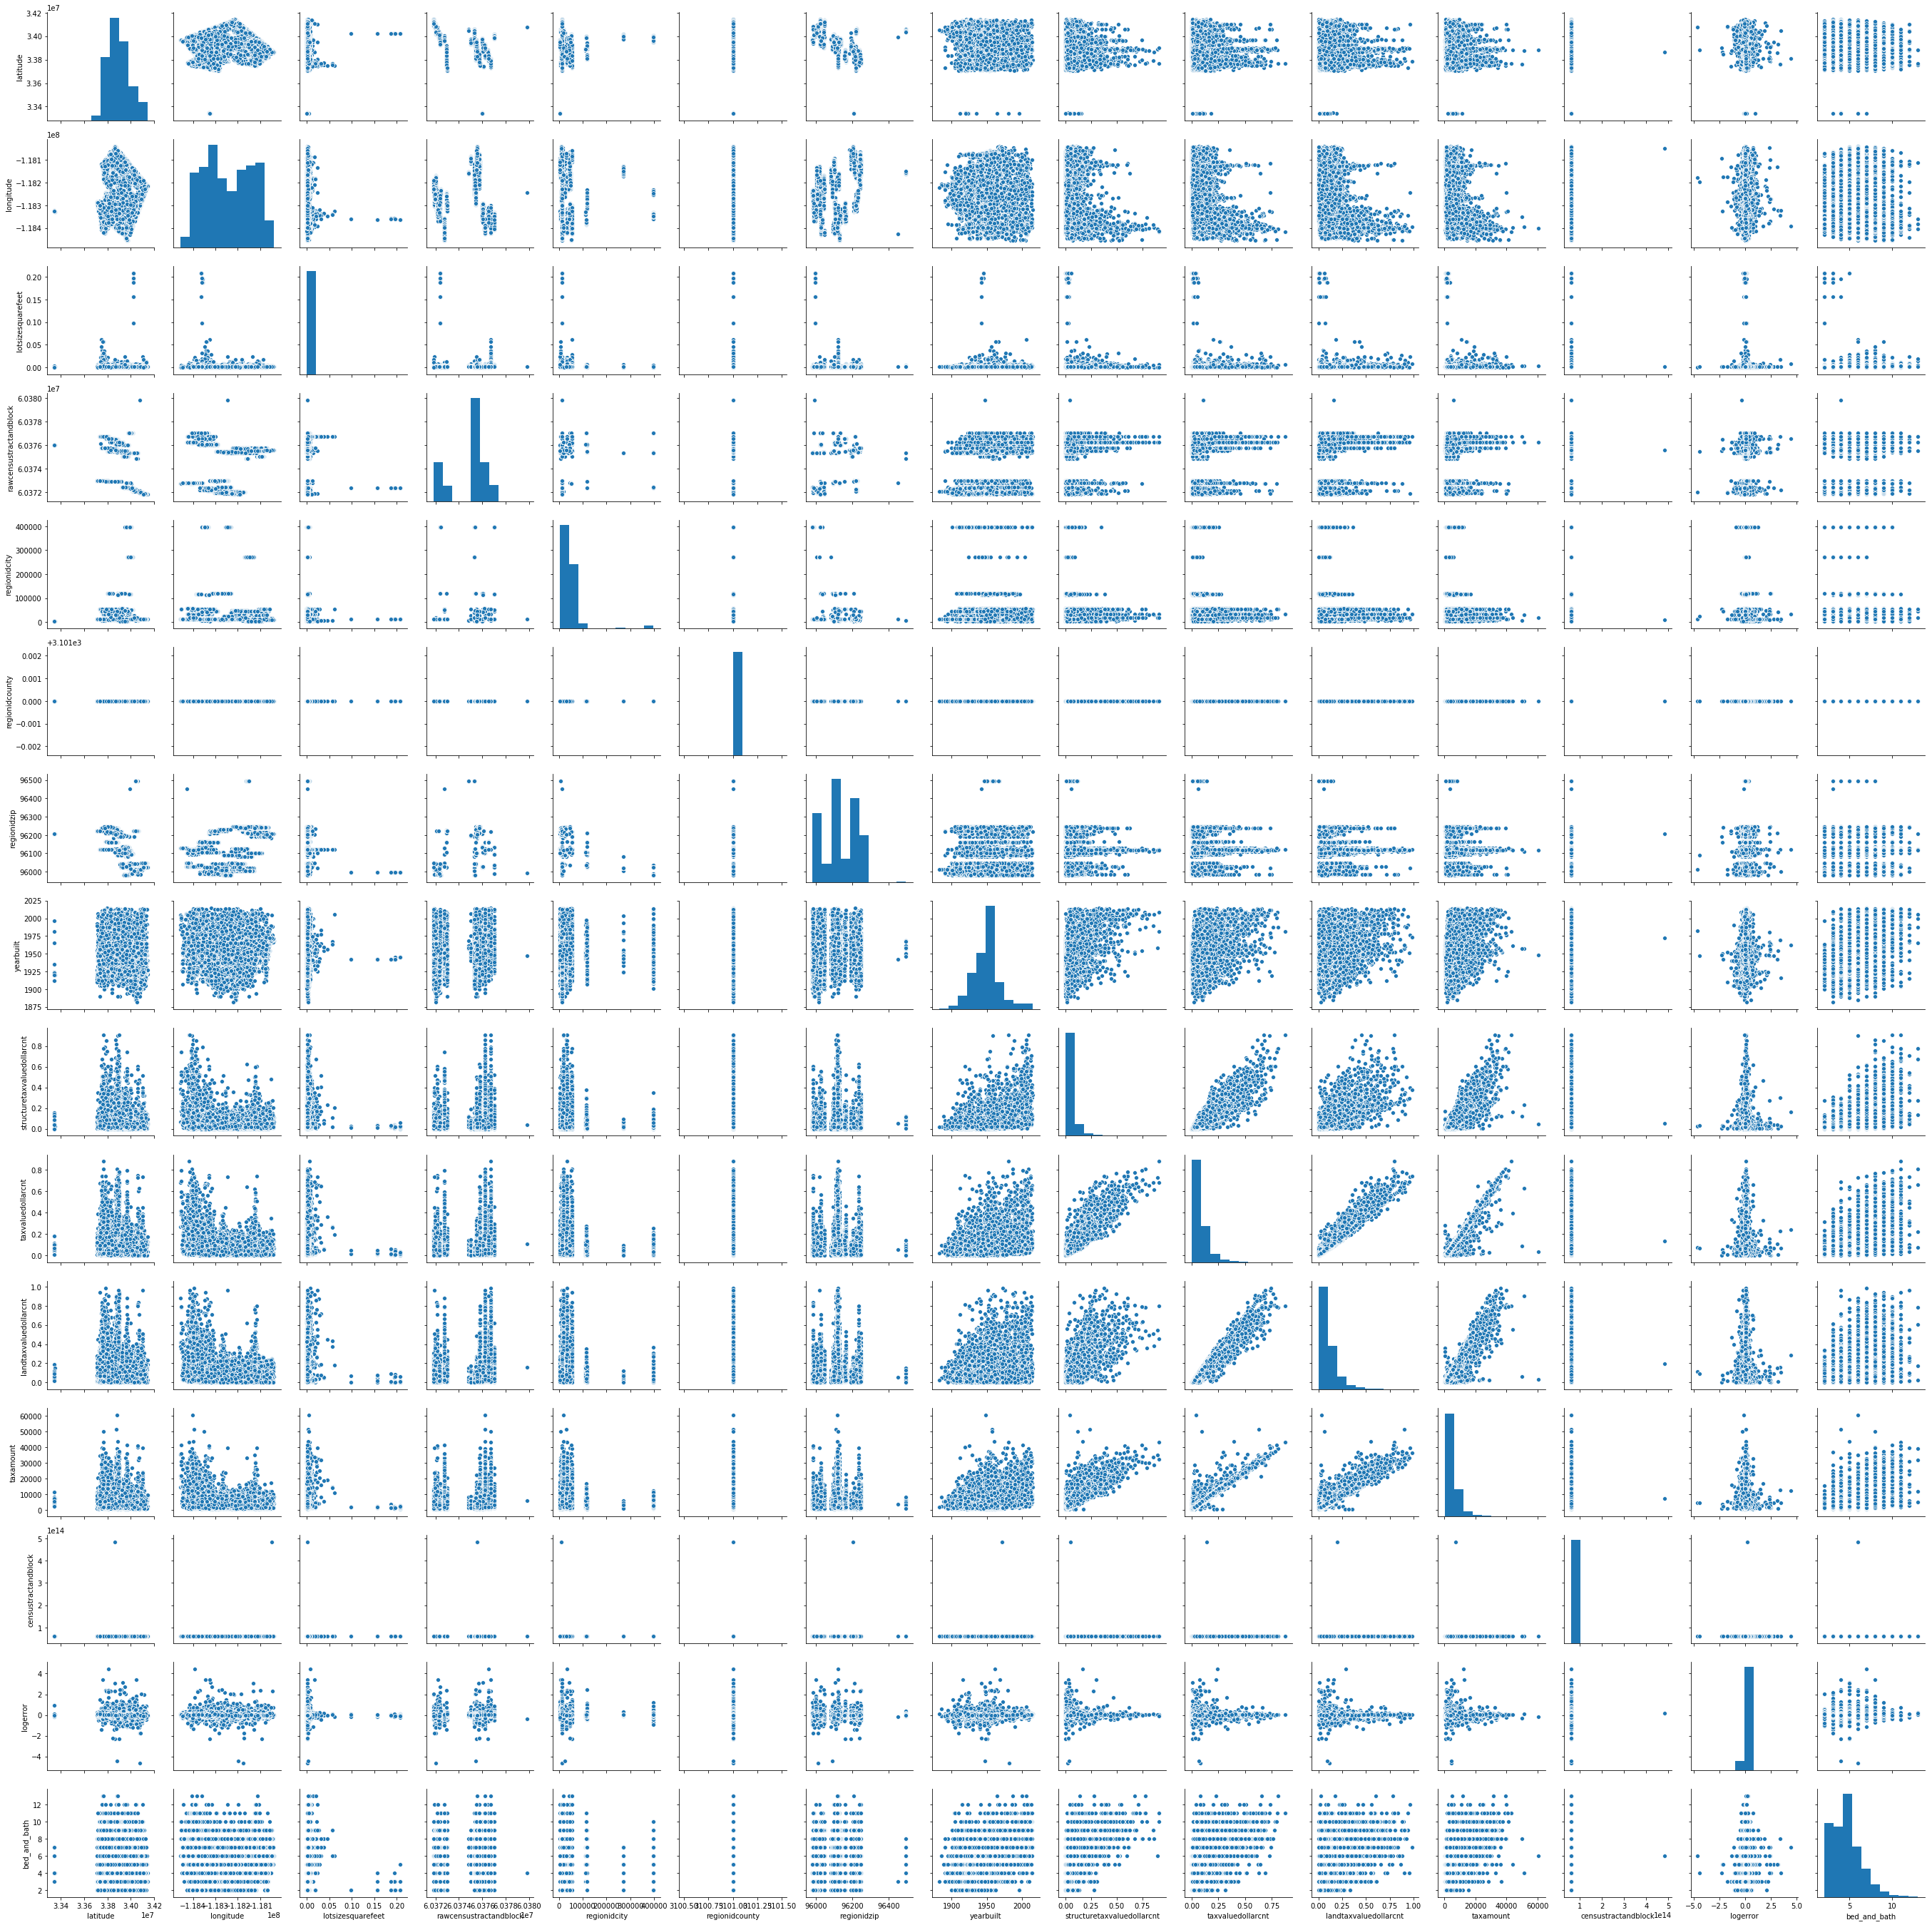

In [52]:
sns.pairplot(df0[num_vars])

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


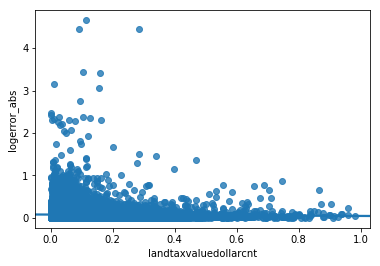

In [53]:
sns.regplot(x='landtaxvaluedollarcnt', y='logerror_abs', data=df0)

In [54]:
df_dumclusts = pd.get_dummies(df['cluster_target_loc'])

df_new = pd.concat([df, df_dumclusts], axis=1)

In [55]:
df_new.head()

id  parcelid  buildingqualitytypeid    latitude    longitude  \
0   2931667  11016594                    4.0  34280990.0 -118488536.0   
2   2444575  12098116                    4.0  34136312.0 -118175032.0   
5   2843942  11509835                    1.0  33870089.0 -118402768.0   
6   1628001  12286022                    7.0  33899475.0 -118212720.0   
10   715639  10854446                    7.0  34164671.0 -118477995.0   

    lotsizesquarefeet propertycountylandusecode  rawcensustractandblock  \
0            0.002352                      0100            6.037107e+07   
2            0.003727                      0100            6.037464e+07   
5            0.000649                      0100            6.037621e+07   
6            0.002051                      0100            6.037542e+07   
10           0.002617                      0100            6.037141e+07   

    regionidcity  regionidcounty ...  regionidzip_  logerror_abs  \
0        12447.0          3101.0 ...      96370.0_        0.0276   
2        47019.0          3101.0 ...      96293.0_        0.0040   
5        29712.0          3101.0 ...      96109.0_        0.2705   
6        24174.0          3101.0 ...      96091.0_        0.0440   
10       12447.0          3101.0 ...      96426.0_        0.3825   

    cluster_target  logerror_bin  logerror_abs_bin  cluster_target_loc  0  1  \
0                0             2                 1                   2  0  0   
2                0             1                 0                   1  0  1   
5                3             0                 3                   0  1  0   
6                0             3                 2                   0  1  0   
10               1             3                 3                   2  0  0   

    2  3  
0   1  0  
2   0  0  
5   0  0  
6   0  0  
10  1  0  

[5 rows x 31 columns]

In [56]:
X = df_new[[0, 1, 2, 3]]
y = df_new[['logerror_abs']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [57]:
[[column, pearsonr(train[column], train.logerror_abs)] for column in X_train] 


[[0, (0.012973761661064384, 0.0028590768513964203)],
 [1, (-0.0214719359898509, 7.954669082195542e-07)],
 [2, (0.019400816175155326, 8.187407238431074e-06)],
 [3, (-0.01871346759960615, 1.691295524913776e-05)]]

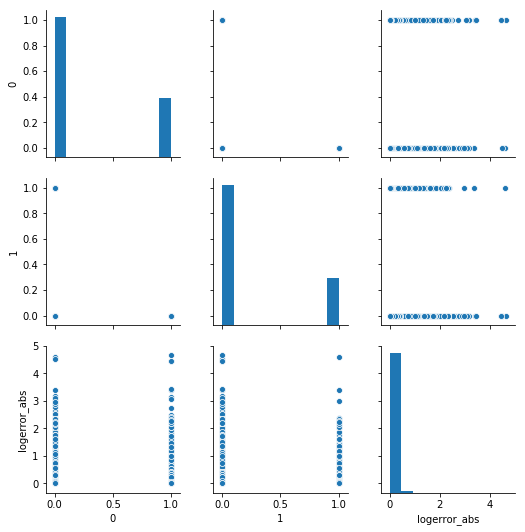

In [58]:
sns.pairplot(df_new[[0,1,'logerror_abs']])

In [66]:
#attempt to make a linear model based solely on cluster 1 as a feature,
# as it seems to have the most correlation. (still poor)

lm1 = LinearRegression()
lm1.fit(X_train[[1]], y_train)
lm1_y_intercept = lm1.intercept_
lm1_coefficients = lm1.coef_
y_pred_lm1 = lm1.predict(X_train[[1]])
mse_lm1 = mean_squared_error(y_train, y_pred_lm1)
r2_lm1 = r2_score(y_train, y_pred_lm1)
print('r^2 value for first regression model: {:.2}'.format(r2_lm1))
print('mean squared error for lmd on test data: {:.2}'.format(mse_lm1))
print('{:.2%} of the variance in the average absolute log error can be explained by the difference of the tax assessed house price by bins of 25,000.'
      .format(r2_lm1))


r^2 value for first regression model: 0.00046
mean squared error for lmd on test data: 0.02
0.05% of the variance in the average absolute log error can be explained by the difference of the tax assessed house price by bins of 25,000.


Text(0.5, 1.0, 'The elbow method for regionidzip and latitude')

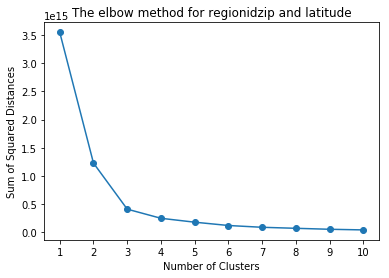

In [77]:
# clustering based on location zip code and latitude: 
X = df[['regionidzip', 'latitude']]

intertias = []
for numclusters in range(1, 11):
    kmeans = KMeans(n_clusters=numclusters)
    kmeans.fit(X)
    intertias.append(kmeans.inertia_)
    
kmeans_perf = pd.DataFrame(list(zip(range(1, 11), intertias)), columns=['n_clusters', 'ssd'])

plt.scatter(kmeans_perf.n_clusters, kmeans_perf.ssd)
plt.plot(kmeans_perf.n_clusters, kmeans_perf.ssd)

plt.xticks(range(1, 11))
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('The elbow method for regionidzip and latitude')

### Here I am going to implement the difference from mean feature that I utilized in my first linear regression project model.  We will see if it creates any utility in making clusters.

In [70]:
from helper import *
df['diff_from_mean'] = df.taxvaluedollarcnt.mean() - df.taxvaluedollarcnt

In [74]:
X = df[['diff_from_mean']]

intertias = []
for numclusters in range(1, 11):
    kmeans = KMeans(n_clusters=numclusters)
    kmeans.fit(X)
    intertias.append(kmeans.inertia_)
    
kmeans_perf = pd.DataFrame(list(zip(range(1, 11), intertias)), columns=['n_clusters', 'ssd'])

Text(0.5, 1.0, 'The elbow method for Difference from mean ')

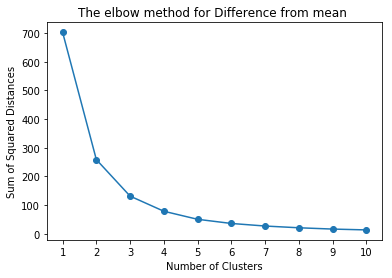

In [76]:
plt.scatter(kmeans_perf.n_clusters, kmeans_perf.ssd)
plt.plot(kmeans_perf.n_clusters, kmeans_perf.ssd)

plt.xticks(range(1, 11))
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('The elbow method for Difference from mean ')

In [78]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
df['cluster_target_diffmean'] = kmeans.predict(X)

In [80]:
df['logerror_abs_bin'] = pd.qcut(df.logerror_abs, 3, labels=False)

tbl = pd.crosstab(df['cluster_target_loc'], df['logerror_abs_bin'])
print(tbl)
stat, p, dof, expected = stats.chi2_contingency(tbl)
print('p-statistic of logerror bins vs location clusters: {}'.format(p))
stat

logerror_abs_bin       0     1     2
cluster_target_loc                  
0                   6466  6479  6630
1                   5762  5619  5240
2                   7119  7517  8089
3                   2779  2298  2060
p-statistic of logerror bins vs location clusters: 4.658771544696633e-41


202.86519016938715

In [81]:
df_dumclusts = pd.get_dummies(df['cluster_target_diffmean'])

df_new = pd.concat([df, df_dumclusts], axis=1)

In [86]:
df_new.head()

id  parcelid  buildingqualitytypeid    latitude    longitude  \
0   2931667  11016594                    4.0  34280990.0 -118488536.0   
2   2444575  12098116                    4.0  34136312.0 -118175032.0   
5   2843942  11509835                    1.0  33870089.0 -118402768.0   
6   1628001  12286022                    7.0  33899475.0 -118212720.0   
10   715639  10854446                    7.0  34164671.0 -118477995.0   

    lotsizesquarefeet propertycountylandusecode  rawcensustractandblock  \
0            0.002352                      0100            6.037107e+07   
2            0.003727                      0100            6.037464e+07   
5            0.000649                      0100            6.037621e+07   
6            0.002051                      0100            6.037542e+07   
10           0.002617                      0100            6.037141e+07   

    regionidcity  regionidcounty ...  cluster_target  logerror_bin  \
0        12447.0          3101.0 ...               0             2   
2        47019.0          3101.0 ...               0             1   
5        29712.0          3101.0 ...               3             0   
6        24174.0          3101.0 ...               0             3   
10       12447.0          3101.0 ...               1             3   

    logerror_abs_bin  cluster_target_loc  diff_from_mean  \
0                  1                   2        0.020184   
2                  0                   1        0.076295   
5                  2                   0       -0.467397   
6                  1                   0        0.078254   
10                 2                   2        0.079554   

    diff_from_mean_class  cluster_target_diffmean  0  1  2  
0                   None                        2  0  0  1  
2                   None                        2  0  0  1  
5                   None                        0  1  0  0  
6                   None                        0  1  0  0  
10                  None                        2  0  0  1  

[5 rows x 33 columns]

In [101]:
X = df_new.drop(columns=['logerror_abs', 'logerror'])
y = df_new[['logerror_abs']]
# X[[0, 'lotsizesquarefeet']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [103]:
lm2 = LinearRegression()
lm2.fit(X_train[[2, 'taxvaluedollarcnt', 'bed_and_bath']], y_train)
lm2_y_intercept = lm2.intercept_
lm2_coefficients = lm2.coef_
y_pred_lm2 = lm2.predict(X_train[[2, 'taxvaluedollarcnt', 'bed_and_bath']])
mse_lm2 = mean_squared_error(y_train, y_pred_lm2)
r2_lm2 = r2_score(y_train, y_pred_lm2)
print('r^2 value for first regression model: {:.2}'.format(r2_lm2))
print('mean squared error for lmd on test data: {:.2}'.format(mse_lm2))
print('{:.2%} of the variance in the average absolute log error can be explained by the difference of the tax assessed house price by bins of 25,000.'
      .format(r2_lm2))

r^2 value for first regression model: 0.0024
mean squared error for lmd on test data: 0.02
0.24% of the variance in the average absolute log error can be explained by the difference of the tax assessed house price by bins of 25,000.
